## Figure 2

![title](../assets/Fig2.png)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import copy
import logging
from pathlib import Path
import scipy
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.stats.multitest

from common import *

# disable matplotlib logger
logging.getLogger("matplotlib.font_manager").disabled = True

# disable seaborn warnings
import warnings
warnings.filterwarnings("ignore")

DATA_PATH = Path(
    "../data"
)
EXPORT_PATH = Path(
    "../results/Figure2"
)
EXPORT_PATH.mkdir(exist_ok=True, parents=True)

COLOR_LEGS = {
    'RF': COLORS['blue'],
    'LF': COLORS['vermillion'],
    'RAnt': COLORS['skyblue'],
    'LAnt': COLORS['orange'],
    "Neck": COLORS['pink'],
    "Bristles": COLORS['green'],
}

COLOR_ANGLES = {
    'Angle_head_roll': COLORS['green'],
    'Angle_head_pitch': COLORS['black'],
    'Angle_antenna_pitch_R': COLORS['skyblue'],
    'Angle_antenna_pitch_L': COLORS['orange'],
}

FIGSIZE = {'width': 1.2, 'length': 0.9}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def normalize_df(df_to_normalize: pd.DataFrame, verbose: bool = False) -> pd.DataFrame:
    """Normalize each segment value within the fly.

    Parameters
    ----------
    df_to_normalize : pd.DataFrame
        Dataframe to normalize.
        Columns: ['Fly', 'Segment', 'Gain', 'Value']

    Returns
    -------
    pd.DataFrame
        Normalized dataframe.
    """
    # copy
    normalized_df = copy.deepcopy(df_to_normalize)

    # normalize each segment values within an experiment
    for fly, group in df_to_normalize.groupby("Fly"):
        for segment in df_to_normalize.Segment.unique():
            # normalize only segment
            ind_segment = group[group.Segment == segment].index
            group_segment = group.loc[ind_segment]
            if group_segment.Value.max() == group_segment.Value.min():
                print(
                    f"Maximum and minimum values in the group {segment} are the same."
                )
            normalized_df.loc[ind_segment, "Value"] = (
                group_segment.Value - group_segment.Value.min()
            ) / (group_segment.Value.max() - group_segment.Value.min() + 1e-9)

            if verbose:
                print(f"Normalizing {segment} in {fly}")
                print(group_segment)

    return normalized_df

def plot_tita_collision_diagram_grooming(
    contact_data,
    collision_pairs,
    time_step=1e-4,
    ax=None,
    export_path=None,
    bar_width=0.7,
    title="",
    alpha=0.75,
):
    """
    Plots the collision diagram for grooming.
    Reverse if collision detected in the reversed order.

    Example:
        fig, ax = plt.subplotsfigsize=(7, 3))
        contact_normal = load_physics_data(
            '/simulation_results/kinematic_replay_grooming_220216_144426',
            'contact_flag'
            )
        plot_collision_diagram_grooming(contact_normal, ax=ax, title='No concave')
        plt.tight_layout()
        plt.show()
    """
    total_length = contact_data.shape[0] * time_step

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 1))

    antennal_seg_colors = {"RAntenna": "#56B4E9", "LAntenna": "#E69F00"}
    leg_names = [
        "RFTibia",
        "RFTarsus",
        "LFTibia",
        "LFTarsus",
    ]

    for i, (ant_segment, leg_segment) in enumerate(collision_pairs):
        index = leg_names.index(leg_segment)
        # print(f'indices between {ant_segment} and {leg_segment} are {collision_pairs[(ant_segment, leg_segment)]}')

        collision = get_collision_data(
            contact_data, collision_pairs[(ant_segment, leg_segment)]
        )
        color = antennal_seg_colors[ant_segment]
        #         print(ant, leg_segment)

        intervals = (
            np.where(np.abs(np.diff(collision, prepend=[0], append=[0])) == 1)[
                0
            ].reshape(-1, 2)
            * time_step
        )
        intervals[:, 1] = intervals[:, 1] - intervals[:, 0]

        ax.broken_barh(
            intervals,
            (index - bar_width * 0.5, bar_width),
            facecolor=color,
            alpha=alpha,
        )

    ax.set_yticks(range(0, len(leg_names)))
    ax.set_yticklabels(leg_names)

    ax.set_ylim(len(leg_names) - 0.5, -0.5)

    if title:
        ax.set_title(title, fontsize=15)

    if export_path is not None:
        fig.savefig(export_path, bbox_inches="tight")


def get_stars(p_value):
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return ""

## Panel B

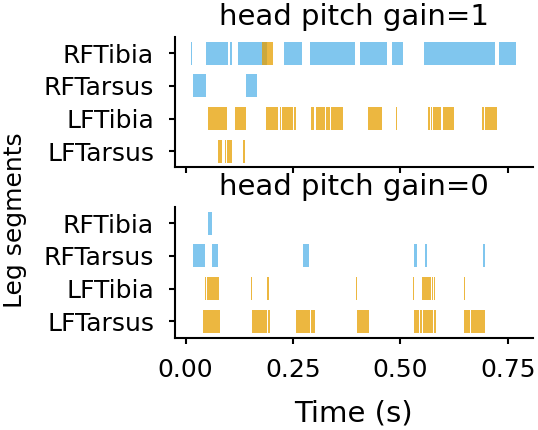

In [3]:
panelb_data = load_data(DATA_PATH / "Fig2_collision_head_pitch.pkl")

with plt.style.context("config.mplstyle"):
    fig, axs = plt.subplots(
        2,
        1,
        figsize=(FIGSIZE["width"] * 1.4, FIGSIZE["length"] * 1.4),
        sharex=True,
        sharey=False,
        dpi=300,
    )

    plot_tita_collision_diagram_grooming(
        panelb_data["gain1_contact"],
        panelb_data["gain1_collision_pairs"],
        ax=axs[0],
    )
    axs[0].set_title("head pitch gain=1", y=0.9)

    plot_tita_collision_diagram_grooming(
        panelb_data["gain0_contact"],
        panelb_data["gain0_collision_pairs"],
        ax=axs[1],
    )
    axs[1].set_title("head pitch gain=0", y=0.9)

    plt.tight_layout(pad=-0.02)
    plt.ylabel("Leg segments", y=0.9)
    axs[1].set_xlabel("Time (s)", fontsize=7)

    fig.savefig(EXPORT_PATH / "Fig2_panelB.png")

    plt.show()

## Panel C

In [4]:
# Data load
panelc_data = load_data(DATA_PATH / "Fig2_head_pitch_silence.pkl")
norm_head_pitch_data = normalize_df(panelc_data)

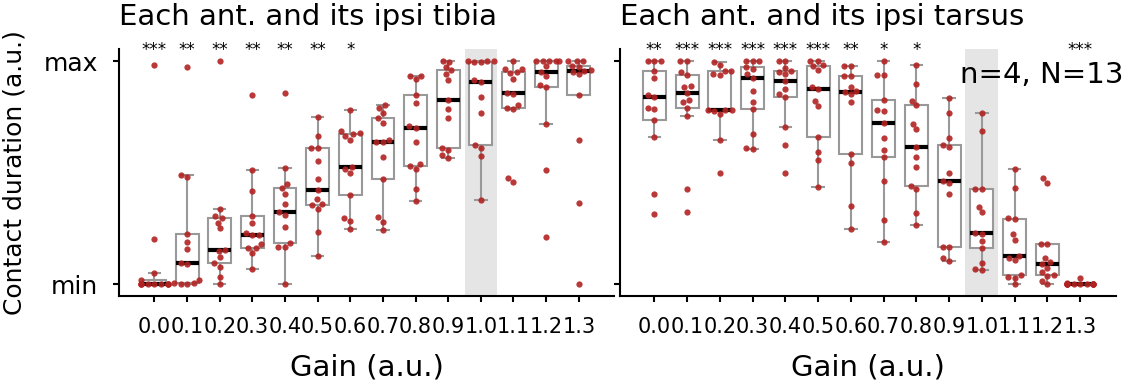

In [5]:
segments = ["Tibia", "Tarsus"]

gains = np.arange(0, 1.4, 0.1)

p_values = {}
p_values_corrected = {}
p_values_corrected_numerical = {}

for segment in segments:
    p_values[segment] = []
    gain_1_distribution = (
        norm_head_pitch_data[
            (norm_head_pitch_data.Segment == segment)
            & (np.isclose(norm_head_pitch_data.Gain, 1.0))
        ]
        .Value.dropna()
        .to_numpy()
    )

    for gain_val in gains:
        second_distribution = (
            norm_head_pitch_data[
                (norm_head_pitch_data.Segment == segment)
                & (np.isclose(norm_head_pitch_data.Gain, gain_val))
            ]
            .Value.dropna()
            .to_numpy()
        )

        p_val_mannu = scipy.stats.mannwhitneyu(
            gain_1_distribution,
            second_distribution,
            alternative="two-sided",
        )
        p_values[segment].append(p_val_mannu.pvalue)

    reject, pvals_corr, _, _ = statsmodels.stats.multitest.multipletests(
        p_values[segment],
        alpha=0.05,
        method="simes-hochberg",
        maxiter=1,
        is_sorted=False,
        returnsorted=False,
    )

    # p_values_corrected
    p_values_corrected[segment] = [get_stars(p) for p in pvals_corr]
    p_values_corrected_numerical[segment] = pvals_corr


# seaborn box plot only tibia segment, x axis willl be gain
with plt.style.context("config.mplstyle"):
    fig, axs = plt.subplots(
        1,
        2,
        figsize=(FIGSIZE["width"] * 3.15, FIGSIZE["length"] * 1.4),
        dpi=300,
        sharey=True,
    )

    sns.swarmplot(
        x="Gain",
        y="Value",
        data=norm_head_pitch_data[norm_head_pitch_data.Segment == "Tibia"],
        color="firebrick",
        alpha=0.9,
        size=1.5,
        ax=axs[0],
    )
    sns.boxplot(
        x="Gain",
        y="Value",
        data=norm_head_pitch_data[norm_head_pitch_data.Segment == "Tibia"],
        palette=["white"],
        showfliers=False,
        ax=axs[0],
        linewidth=0.5,
        width=0.7,
        medianprops={"color": "black", "linewidth": 1.0},
    )

    sns.swarmplot(
        x="Gain",
        y="Value",
        data=norm_head_pitch_data[norm_head_pitch_data.Segment == "Tarsus"],
        color="firebrick",
        alpha=0.9,
        size=1.5,
        ax=axs[1],
    )
    sns.boxplot(
        x="Gain",
        y="Value",
        data=norm_head_pitch_data[norm_head_pitch_data.Segment == "Tarsus"],
        palette=["white"],
        showfliers=False,
        ax=axs[1],
        linewidth=0.5,
        width=0.7,
        medianprops={"color": "black", "linewidth": 1.0},
    )

    axs[0].set_ylabel("Contact duration (a.u.)")
    axs[0].set_title("Each ant. and its ipsi tibia", loc="left")
    axs[1].set_title("Each ant. and its ipsi tarsus", loc="left")

    for i in range(2):
        axs[i].set_xlabel("Gain (a.u.)", fontsize=7)
        axs[i].set_xticklabels([f"{x:.1f}" for x in np.arange(0, 1.4, 0.1)], fontsize=5)
        axs[i].axvspan(9.5, 10.5, color="grey", alpha=0.2, lw=0)

    axs[0].set_yticks([0, 1], ["min", "max"])
    axs[1].set_ylabel("")

    # put text on the second axis
    axs[1].text(
        0.85,
        0.9,
        "n=4, N=13",
        horizontalalignment="center",
        verticalalignment="center",
        transform=axs[1].transAxes,
    )
    # add stars
    for i, segment in enumerate(p_values_corrected):
        for xloc, p_val in enumerate(p_values_corrected[segment]):
            axs[i].text(
                xloc,
                1.05,
                p_val,
                ha="center",
                va="center",
                color="black",
                fontsize=4,
                # fontweight="bold",
            )

    plt.tight_layout(pad=-0.01)
    fig.savefig(EXPORT_PATH / "Fig2_panelC.png")
    plt.show()

## Panel E

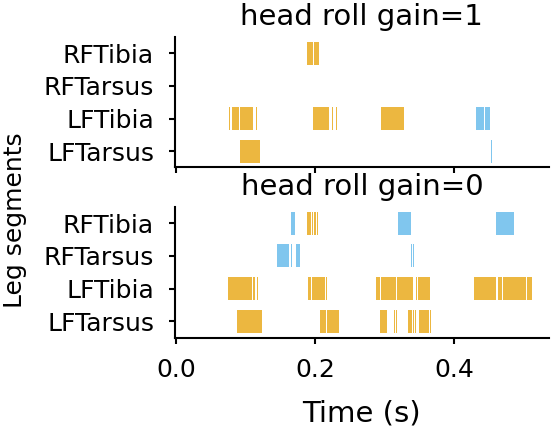

In [6]:
panelb_data = load_data(DATA_PATH / "Fig2_collision_head_roll.pkl")

with plt.style.context("config.mplstyle"):
    fig, axs = plt.subplots(
        2,
        1,
        figsize=(FIGSIZE["width"] * 1.4, FIGSIZE["length"] * 1.4),
        sharex=True,
        sharey=False,
        dpi=300,
    )

    plot_tita_collision_diagram_grooming(
        panelb_data["gain1_contact"],
        panelb_data["gain1_collision_pairs"],
        ax=axs[0],
    )
    axs[0].set_title("head roll gain=1", y=0.9)

    plot_tita_collision_diagram_grooming(
        panelb_data["gain0_contact"],
        panelb_data["gain0_collision_pairs"],
        ax=axs[1],
    )
    axs[1].set_title("head roll gain=0", y=0.9)

    plt.tight_layout(pad=-0.02)
    plt.ylabel("Leg segments", y=0.9)
    axs[1].set_xlabel("Time (s)", fontsize=7)

    fig.savefig(EXPORT_PATH / "Fig2_panelE.png")

    plt.show()

## Panel F

In [7]:
panelf_data_uni_r = load_data(DATA_PATH / "Fig2_head_roll_uni_right_silence.pkl")
panelf_data_uni_l = load_data(DATA_PATH / "Fig2_head_roll_uni_left_silence.pkl")

# normalize each segment value within the fly
norm_head_roll_uniR = normalize_df(panelf_data_uni_r)
norm_head_roll_uniL = normalize_df(panelf_data_uni_l)

# Concat
# concat both normalized dfs
norm_head_roll = pd.concat(
    [norm_head_roll_uniR, norm_head_roll_uniL]
).reset_index(drop=True)

Maximum and minimum values in the group Contra_Tarsus_Ant_R_right are the same.
Maximum and minimum values in the group Contra_Tarsus_Ant_R_right are the same.
Maximum and minimum values in the group Contra_Tarsus_Ant_R_right are the same.
Maximum and minimum values in the group Contra_Tarsus_Ant_R_right are the same.
Maximum and minimum values in the group Contra_Tarsus_Ant_R_right are the same.
Maximum and minimum values in the group Contra_Tarsus_Ant_L_left are the same.
Maximum and minimum values in the group Contra_Tarsus_Ant_L_left are the same.
Maximum and minimum values in the group Contra_Tarsus_Ant_L_left are the same.
Maximum and minimum values in the group Contra_Tarsus_Ant_L_left are the same.


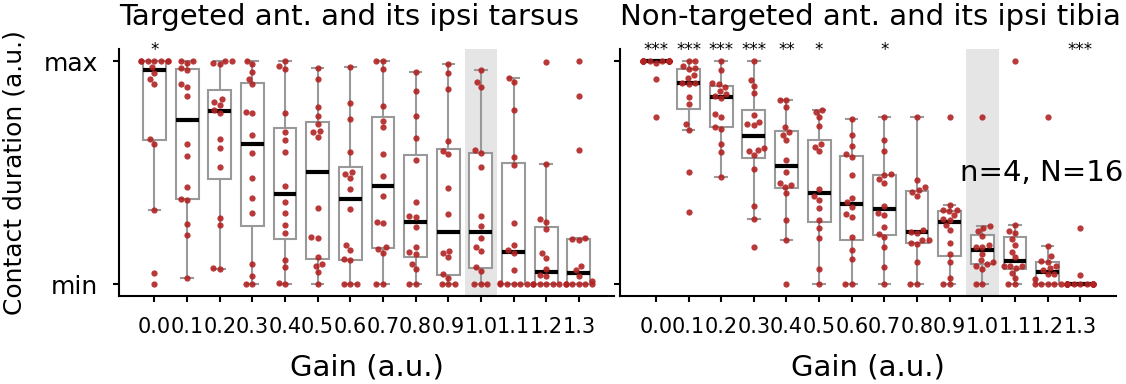

In [8]:
segments = [
    ["Ipsi_Tarsus_Ant_L_left", "Ipsi_Tarsus_Ant_R_right"],
    ["Ipsi_Tibia_Ant_R_left", "Ipsi_Tibia_Ant_L_right"],
]

gains = np.arange(0, 1.4, 0.1)

p_values_head_roll = {}
p_values_head_roll_corrected = {}
p_values_head_roll_corrected_numeric = {}

for segment_pair in segments:
    p_values_head_roll["_".join(segment_pair[:])] = []
    gain_1_distribution = (
        norm_head_roll[
            (norm_head_roll.Segment.isin(segment_pair))
            & (np.isclose(norm_head_roll.Gain, 1.0))
        ]
        .Value.dropna()
        .to_numpy()
    )

    for gain_val in gains:
        second_distribution = (
            norm_head_roll[
                (norm_head_roll.Segment.isin(segment_pair))
                & (np.isclose(norm_head_roll.Gain, gain_val))
            ]
            .Value.dropna()
            .to_numpy()
        )

        p_val_mannu = scipy.stats.mannwhitneyu(
            gain_1_distribution,
            second_distribution,
            alternative="two-sided",
        )

        p_values_head_roll["_".join(segment_pair[:])].append(p_val_mannu.pvalue)

    reject, pvals_corr, _, _ = statsmodels.stats.multitest.multipletests(
        p_values_head_roll["_".join(segment_pair[:])],
        alpha=0.05,
        method="simes-hochberg",
        maxiter=1,
        is_sorted=False,
        returnsorted=False,
    )

    p_values_head_roll_corrected["_".join(segment_pair[:])] = [
        get_stars(p) for p in pvals_corr
    ]
    p_values_head_roll_corrected_numeric["_".join(segment_pair[:])] = pvals_corr

with plt.style.context("./config.mplstyle"):

    fig, axs = plt.subplots(
        1,
        2,
        figsize=(FIGSIZE["width"] * 3.15, FIGSIZE["length"] * 1.4),
        dpi=300,
        sharey=True,
    )

    sns.swarmplot(
        x="Gain",
        y="Value",
        data=norm_head_roll[
            norm_head_roll.Segment.isin(
                ["Ipsi_Tarsus_Ant_L_left", "Ipsi_Tarsus_Ant_R_right"]
            )
        ],
        color="firebrick",
        alpha=0.9,
        size=1.5,
        ax=axs[0],
    )
    sns.boxplot(
        x="Gain",
        y="Value",
        data=norm_head_roll[
            norm_head_roll.Segment.isin(
                ["Ipsi_Tarsus_Ant_L_left", "Ipsi_Tarsus_Ant_R_right"]
            )
        ],
        palette=["white"],
        showfliers=False,
        ax=axs[0],
        linewidth=0.5,
        width=0.7,
        medianprops={"color": "black", "linewidth": 1.0},
    )

    sns.swarmplot(
        x="Gain",
        y="Value",
        data=norm_head_roll[
            norm_head_roll.Segment.isin(
                ["Ipsi_Tibia_Ant_R_left", "Ipsi_Tibia_Ant_L_right"]
            )
        ],
        color="firebrick",
        alpha=0.9,
        size=1.5,
        ax=axs[1],
    )
    sns.boxplot(
        x="Gain",
        y="Value",
        data=norm_head_roll[
            norm_head_roll.Segment.isin(
                ["Ipsi_Tibia_Ant_R_left", "Ipsi_Tibia_Ant_L_right"]
            )
        ],
        palette=["white"],
        showfliers=False,
        ax=axs[1],
        linewidth=0.5,
        width=0.7,
        medianprops={"color": "black", "linewidth": 1.0},
    )

    axs[0].set_ylabel("Contact duration (a.u.)")
    axs[1].set_ylabel("")
    axs[0].set_title("Targeted ant. and its ipsi tarsus", loc="left")
    axs[1].set_title("Non-targeted ant. and its ipsi tibia", loc="left")

    for i in range(2):
        axs[i].set_xlabel("Gain (a.u.)", fontsize=7)
        axs[i].set_xticklabels([f"{x:.1f}" for x in np.arange(0, 1.4, 0.1)], fontsize=5)
        axs[i].axvspan(9.5, 10.5, color="grey", alpha=0.2, lw=0)

    axs[0].set_yticks([0, 1], ["min", "max"])
    axs[1].set_ylabel("")

    axs[1].text(
        0.85,
        0.5,
        "n=4, N=16",
        horizontalalignment="center",
        verticalalignment="center",
        transform=axs[1].transAxes,
    )

    # add stars
    for i, segment in enumerate(p_values_head_roll_corrected):
        for xloc, p_val in enumerate(p_values_head_roll_corrected[segment]):
            axs[i].text(
                xloc,
                1.05,
                p_val,
                ha="center",
                va="center",
                color="black",
                fontsize=4,
                # fontweight="bold",
            )

    # plot_utils.set_outward_spines(axs)
    plt.tight_layout(pad=-0.01)

    fig.savefig(EXPORT_PATH / "Fig2_panelF.png")
    plt.show()

## Panel H

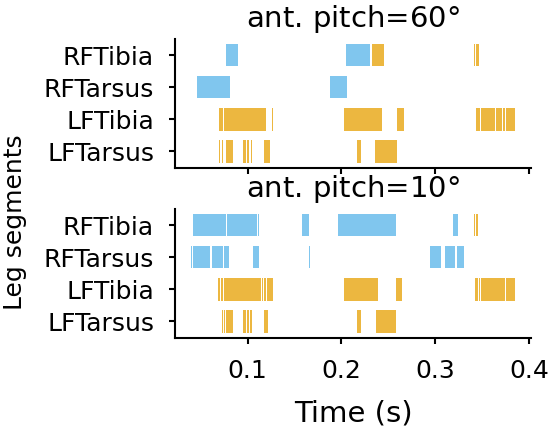

In [9]:
panelh_data = load_data(DATA_PATH / "Fig2_collision_ant_pitch.pkl")

with plt.style.context("config.mplstyle"):
    fig, axs = plt.subplots(
        2,
        1,
        figsize=(FIGSIZE["width"] * 1.4, FIGSIZE["length"] * 1.4),
        sharex=True,
        sharey=False,
        dpi=300,
    )

    plot_tita_collision_diagram_grooming(
        panelh_data["angle60_contact"],
        panelh_data["angle60_collision_pairs"],
        ax=axs[0],
    )
    axs[0].set_title("ant. pitch=60$\degree$", y=0.9)

    plot_tita_collision_diagram_grooming(
        panelh_data["angle10_contact"],
        panelh_data["angle10_collision_pairs"],
        ax=axs[1],
    )
    axs[1].set_title("ant. pitch=10$\degree$", y=0.9)

    plt.tight_layout(pad=-0.02)
    plt.ylabel("Leg segments", y=0.9)
    axs[1].set_xlabel("Time (s)", fontsize=7)

    fig.savefig(EXPORT_PATH / "Fig2_panelH.png")

    plt.show()

## Panel I

In [10]:
paneli_data_uni_r = load_data(DATA_PATH / "Fig2_ant_pitch_uni_right_silence.pkl")
paneli_data_uni_l = load_data(DATA_PATH / "Fig2_ant_pitch_uni_left_silence.pkl")

# normalize each segment value within the fly
norm_ant_pitch_uniR = normalize_df(paneli_data_uni_r)
norm_ant_pitch_uniL = normalize_df(paneli_data_uni_l)

# Concat
# concat both normalized dfs
norm_ant_pitch = pd.concat(
    [norm_ant_pitch_uniR, norm_ant_pitch_uniL]
).reset_index(drop=True)

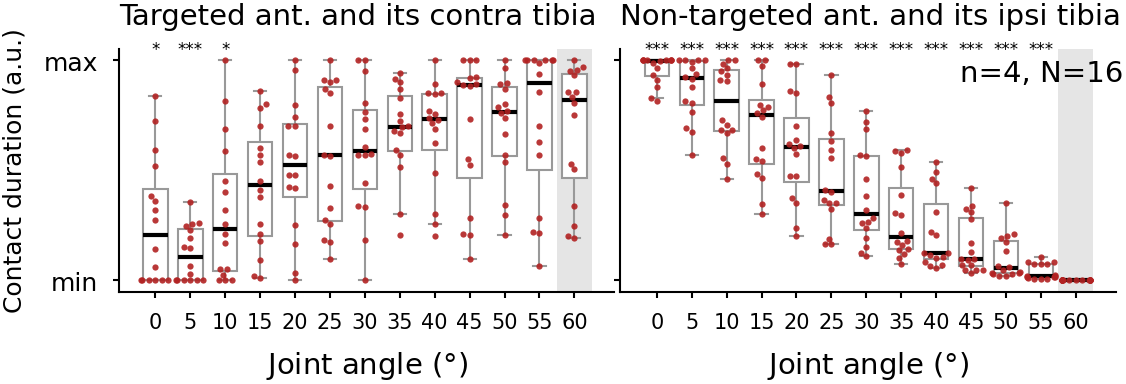

In [11]:
segments = [
    ["Contra_Tibia_Ant_R_right", "Contra_Tibia_Ant_L_left"],
    ["Ipsi_Tibia_Ant_R_left", "Ipsi_Tibia_Ant_L_right"],
]

gains = np.arange(0, 0.65, 0.05)

p_values_ant_pitch = {}
p_values_ant_pitch_corrected = {}
p_values_ant_pitch_corrected_numeric = {}
for segment_pair in segments:
    p_values_ant_pitch["_".join(segment_pair[:])] = []
    gain_1_distribution = (
        norm_ant_pitch[
            (norm_ant_pitch.Segment.isin(segment_pair))
            & (np.isclose(norm_ant_pitch.Gain, 0.6))
        ]
        .Value.dropna()
        .to_numpy()
    )

    for gain_val in gains:
        second_distribution = (
            norm_ant_pitch[
                (norm_ant_pitch.Segment.isin(segment_pair))
                & (np.isclose(norm_ant_pitch.Gain, gain_val))
            ]
            .Value.dropna()
            .to_numpy()
        )

        p_val_mannu = scipy.stats.mannwhitneyu(
            gain_1_distribution,
            second_distribution,
            alternative="two-sided",
        )

        p_values_ant_pitch["_".join(segment_pair[:])].append(p_val_mannu.pvalue)

    reject, pvals_corr, _, _ = statsmodels.stats.multitest.multipletests(
        p_values_ant_pitch["_".join(segment_pair[:])],
        alpha=0.05,
        method="simes-hochberg",
        maxiter=1,
        is_sorted=False,
        returnsorted=False,
    )

    # p_values_ant_pitch_corrected
    p_values_ant_pitch_corrected["_".join(segment_pair[:])] = [
        get_stars(p) for p in pvals_corr
    ]
    p_values_ant_pitch_corrected_numeric["_".join(segment_pair[:])] = pvals_corr

with plt.style.context("./config.mplstyle"):
    fig, axs = plt.subplots(
        1,
        2,
        figsize=(FIGSIZE["width"] * 3.15, FIGSIZE["length"] * 1.4),
        dpi=300,
        sharey=True,
    )

    sns.swarmplot(
        x="Gain",
        y="Value",
        data=norm_ant_pitch[
            norm_ant_pitch.Segment.isin(
                ["Contra_Tibia_Ant_R_right", "Contra_Tibia_Ant_L_left"]
            )
        ],
        color="firebrick",
        alpha=0.9,
        size=1.5,
        ax=axs[0],
    )
    sns.boxplot(
        x="Gain",
        y="Value",
        data=norm_ant_pitch[
            norm_ant_pitch.Segment.isin(
                ["Contra_Tibia_Ant_R_right", "Contra_Tibia_Ant_L_left"]
            )
        ],
        palette=["white"],
        showfliers=False,
        ax=axs[0],
        linewidth=0.5,
        width=0.7,
        medianprops={"color": "black", "linewidth": 1.0},
    )

    sns.swarmplot(
        x="Gain",
        y="Value",
        data=norm_ant_pitch[
            norm_ant_pitch.Segment.isin(
                ["Ipsi_Tibia_Ant_R_left", "Ipsi_Tibia_Ant_L_right"]
            )
        ],
        color="firebrick",
        alpha=0.9,
        size=1.5,
        ax=axs[1],
    )
    sns.boxplot(
        x="Gain",
        y="Value",
        data=norm_ant_pitch[
            norm_ant_pitch.Segment.isin(
                ["Ipsi_Tibia_Ant_R_left", "Ipsi_Tibia_Ant_L_right"]
            )
        ],
        palette=["white"],
        showfliers=False,
        ax=axs[1],
        linewidth=0.5,
        width=0.7,
        medianprops={"color": "black", "linewidth": 1.0},
    )

    axs[0].set_ylabel("Contact duration (a.u.)")
    axs[0].set_title("Targeted ant. and its contra tibia", loc="left")
    axs[1].set_title("Non-targeted ant. and its ipsi tibia", loc="left")

    for i in range(2):
        axs[i].set_xlabel("Joint angle ($\degree$)", fontsize=7)
        axs[i].set_xticklabels([f"{x}" for x in np.arange(0, 65, 5)], fontsize=5)
        axs[i].axvspan(11.5, 12.5, color="grey", alpha=0.2, lw=0)
    axs[0].set_yticks([0, 1], ["min", "max"])
    axs[1].set_ylabel("")

    axs[1].text(
        0.85,
        0.9,
        "n=4, N=16",
        horizontalalignment="center",
        verticalalignment="center",
        transform=axs[1].transAxes,
    )

    # add stars
    for i, segment in enumerate(p_values_ant_pitch_corrected):
        for xloc, p_val in enumerate(p_values_ant_pitch_corrected[segment]):
            axs[i].text(
                xloc,
                1.05,
                p_val,
                ha="center",
                va="center",
                color="black",
                fontsize=4,
                # fontweight="bold",
            )

    # plot_utils.set_outward_spines(axs)
    plt.tight_layout(pad=-0.01)

    fig.savefig(EXPORT_PATH / "Fig2_panelI.png")
    plt.show()